In [ ]:
import math
import numpy as np
import datetime
# import scipy.signal as signal
# import scipy.io.wavfile as wav
# import scipy.io.wavfile as wav
import os, random, sys
# from pylab import plot,show, figure, imshow
# import matplotlib.pyplot as plt
import librosa.core as audio

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed,Dense,LSTM,Input,Lambda,Dropout #,CuDNNLSTM, CuDNNGRU,,BatchNormalization,
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers as reg
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import normalize, MinMaxScaler, MaxAbsScaler
import tensorflow.keras.backend as K
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [12]:
def genStartVal(vLen,nLen):
    startVal = math.floor(abs(np.random.randn()*0.02*vLen))
    if startVal+vLen < nLen:
        return startVal
    else:
        genStartVal(vLen,nLen)

def spectrumSequence(time_series_data,nfft,fs_):
    nFiles = len(time_series_data)
    sequence = []
    lengths = []
    for idx in range(nFiles):
        thisData = time_series_data[idx].T.squeeze()
        spectrum =  audio.stft(thisData,n_fft=nfft,hop_length=int(nfft/2),center=False)
        Mag = np.abs(spectrum).T
        sequence.append(Mag)
        lengths.append(len(Mag))
    return sequence,lengths

def pad_seq(allData,maxlen):
    paddedData = pad_sequences(allData,maxlen=maxlen,dtype='float32',value=0.0)
    return paddedData

def back_to_wav(pred):
    pred = pred.squeeze()
    scaler2.inverse_transform(pred)
    scaler1.inverse_transform(pred)
    pred = pred.T
    wav = audio.istft(pred)
    return wav.T.squeeze()


def softMasking(y):
    input = y[0]
    y1_hat = y[1]
    y2_hat = y[2]
    s1,s2 = computeSoftMask(y1_hat,y2_hat)
    y1_tilde = tf.multiply(s1,input)
    y2_tilde = tf.multiply(s2,input)
    return [y1_tilde, y2_tilde]

def maskedOutShape(shape):
    shape_0 = list(shape[0])
    shape_1 = list(shape[1])
    return [tuple(shape_0),tuple(shape_1)]

def computeSoftMask(y1,y2):
    y1 = K.abs(y1)
    y2 = K.abs(y2)
    m1 = tf.divide(y1,tf.add(y1,y2))
    m2 = tf.divide(y2,tf.add(y1,y2))
    # m2 = 1 - m1
    return [m1,m2]

In [13]:
# Dataset: MIR-1k
# Training and Validation sets are prepared automatically by Keras later.
# ----------------------------------------------

#dataset = os.getcwd()+"/../input/mir1k/MIR-1k/"
#noisedataset  = os.getcwd()+"/../input/mir1k/Noises/"

import soundfile as sf

mixed = []
target = []
noise = []

path = "./../data/clarity_CEC2_data/clarity_data/dev/scenes/S060"

for i in range(1, 51):
    
    if i < 10:
        s = '0' + str(i)
        
    else:
        s = str(i)
        
    mixed_sample, rate_m = sf.read(path + s + "_mix_CH1.wav")
    target_sample, rate_t = sf.read(path + s + "_target_CH1.wav")
    noise_sample, rate_n = sf.read(path + s + "_interferer_CH1.wav")
    
    mixed.append(mixed_sample[:,0])
    target.append(target_sample[:,0])
    noise.append(noise_sample[:,0])

In [14]:
print(len(mixed[0]))

287990


In [15]:
#for root,_,files in os.walk(dataset):
#    files = sorted(files)
    
mir_music = noise
mir_voice = target

"""
for idx,f in enumerate(files):
    if f.endswith(".wav"):
        data,srate = audio.load(os.path.join(root,f),sr=None,mono=False)
        music = data[0,:]
        voice = data[1,:]
        mir_music.append(music)
        mir_voice.append(voice)
"""

'\nfor idx,f in enumerate(files):\n    if f.endswith(".wav"):\n        data,srate = audio.load(os.path.join(root,f),sr=None,mono=False)\n        music = data[0,:]\n        voice = data[1,:]\n        mir_music.append(music)\n        mir_voice.append(voice)\n'

In [16]:
musicData = []
voiceData = []
musicAddedData = []

for each,thisVoice in enumerate(mir_voice):
    thisMusic = mir_music[each]
    voiceBit = normalize(thisVoice.reshape(1,-1),norm='max')
    musicBit = normalize(thisMusic.reshape(1,-1),norm='max')
    #musicAdd = 0.5*np.add(voiceBit,musicBit)
    musicAdd = mixed[each]
    voiceData.append(voiceBit)
    musicData.append(musicBit)
    musicAddedData.append(musicAdd)

In [17]:
print(len(musicAddedData))
print(musicAddedData[0].shape)

50
(287990,)


In [18]:
nfft = 1024
fs = 16000

x_data,l1  = spectrumSequence(musicAddedData,nfft,fs)
y1_data,l2 = spectrumSequence(voiceData,nfft,fs)
y2_data,l3 = spectrumSequence(musicData,nfft,fs)

assert len(x_data) == len(y1_data) == len(y2_data)

# ----------------------------------------------
# Normalize Spectra to the Input
# ----------------------------------------------

scaler1 = MaxAbsScaler(copy=False)
scaler2 = MinMaxScaler(feature_range=(0.0,1.0),copy=False)

for idx in range(len(x_data)):
    scaler1.fit_transform(x_data[idx])
    # scaler1.fit_transform(x_data[idx])
    scaler1.fit_transform(y1_data[idx])
    scaler1.fit_transform(y2_data[idx])
    # scaler2.fit(x_data[idx])
    scaler2.fit_transform(x_data[idx])
    scaler2.fit_transform(y1_data[idx])
    scaler2.fit_transform(y2_data[idx])

In [19]:
l1 = max(l1)
l2 = max(l2)
l3 = max(l3)
maxL = max(l1,l2,l3)

del mir_music, mir_voice #, combinedDataFrames
#
train_x = pad_seq(x_data,maxL)
y1      = pad_seq(y1_data,maxL)
y2      = pad_seq(y2_data,maxL)


del x_data, y1_data, y2_data

In [20]:
print(train_x.shape)

(50, 599, 513)


In [23]:
batch_size = 10
learning_rate = 1e-4
decay_ = 1e-3
epochs = 2
n_units = 600 #int(2*nfft/1)

shape = train_x.shape[1:]
n_outs = train_x.shape[2] # Note: Not train_x.shape[1:], which returns shape for input_shape, instead of int.


# # CPU Version :: Functional API
regularizer = reg.l2(0.05)
input_1 = Input(shape=shape)
# input_mask = Masking(mask_value=0.,input_shape=shape)(input)
hid1 = LSTM(n_units,return_sequences=True, activation='relu')(input_1)
dp1  = Dropout(0.2)(hid1)
hid2 = LSTM(n_units,return_sequences=True, activation='relu')(dp1)
dp2  = Dropout(0.2)(hid2)
hid3 = LSTM(n_units,return_sequences=True, activation='relu')(dp2)
y1_hat = TimeDistributed(Dense(train_x.shape[2], activation='softmax', input_shape=train_x.shape[1:]), name='y1_hat')(hid3)
y2_hat = TimeDistributed(Dense(train_x.shape[2], activation='softmax', input_shape=train_x.shape[1:]), name='y2_hat')(hid3)
out1,out2 = Lambda(softMasking,maskedOutShape,name='softMask')([input_1,y1_hat,y2_hat])

model = Model(inputs=input_1,outputs=[out1,out2])
model.summary()
#
#
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='kullback_leibler_divergence',optimizer=opt, metrics=['acc','mse']) #kullback_leibler_divergence

curdir = os.getcwd()+"/logs/"

if not os.path.exists('Checkpoints'):
    os.makedirs('Checkpoints')

chkpoint_path = os.getcwd()+"/Checkpoints/ModelChkpoint_epoch{epoch:02d}_vLoss{val_loss:.2f}.hdf5"

tensorboard = TensorBoard(log_dir=curdir)

checkpt = ModelCheckpoint(filepath=chkpoinpath,monitor='val_softMask_acc',save_best_only=True,save_weights_only=False)
earlystop = EarlyStopping(monitor='val_softMask_acc', min_delta=1e-3, patience=10)
history = model.fit(train_x,[y1,y2],batch_size=batch_size,epochs=epochs,validation_split=0.825,callbacks=[tensorboard,checkpt,earlystop])

if not os.path.exists('Models'):
    os.makedirs('Models')

date_time = datetime.datetime.now()
model_path = os.getcwd()+f"/Models/Model_{date_time}.hdf5"
model.save(model_path)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 599, 513)]   0           []                               
                                                                                                  
 lstm_9 (LSTM)                  (None, 599, 600)     2673600     ['input_4[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 599, 600)     0           ['lstm_9[0][0]']                 
                                                                                                  
 lstm_10 (LSTM)                 (None, 599, 600)     2882400     ['dropout_6[0][0]']              
                                                                                            

2023-01-14 21:51:51.351966: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51624216 exceeds 10% of free system memory.
2023-01-14 21:51:51.371629: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51624216 exceeds 10% of free system memory.
2023-01-14 21:51:51.392262: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51624216 exceeds 10% of free system memory.


1/1 [==============================] - 23s 23s/step - loss: 113.7979 - softMask_loss: 28.4089 - softMask_1_loss: 85.3890 - softMask_acc: 0.2101 - softMask_mse: 0.0141 - softMask_1_acc: 0.3929 - softMask_1_mse: 0.0234 - val_loss: 86.5669 - val_softMask_loss: 27.3085 - val_softMask_1_loss: 59.2584 - val_softMask_acc: 0.2531 - val_softMask_mse: 0.0154 - val_softMask_1_acc: 0.5070 - val_softMask_1_mse: 0.0158
Epoch 2/2
1/1 [==============================] - 16s 16s/step - loss: 113.7596 - softMask_loss: 28.4146 - softMask_1_loss: 85.3450 - softMask_acc: 0.2099 - softMask_mse: 0.0141 - softMask_1_acc: 0.3921 - softMask_1_mse: 0.0234 - val_loss: 86.5380 - val_softMask_loss: 27.3174 - val_softMask_1_loss: 59.2205 - val_softMask_acc: 0.2525 - val_softMask_mse: 0.0154 - val_softMask_1_acc: 0.5061 - val_softMask_1_mse: 0.0157


In [24]:
model = tf.keras.models.load_model(model_path, compile = False)

model.summary()

s_pred_voice, s_pred_music = model.predict(train_x[:1])

print(s_pred_voice.shape)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 599, 513)]   0           []                               
                                                                                                  
 lstm_9 (LSTM)                  (None, 599, 600)     2673600     ['input_4[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 599, 600)     0           ['lstm_9[0][0]']                 
                                                                                                  
 lstm_10 (LSTM)                 (None, 599, 600)     2882400     ['dropout_6[0][0]']              
                                                                                            

In [25]:
import pandas as pd

In [26]:
s_pred_voice_wav = back_to_wav(s_pred_voice)
s_pred_noise_wav = back_to_wav(s_pred_music)

print(s_pred_voice_wav.shape)
print(s_pred_noise_wav.shape)

#DF = pd.DataFrame(wav)
#DF.to_csv('outputfile.csv', index=False)

(153088,)
(153088,)


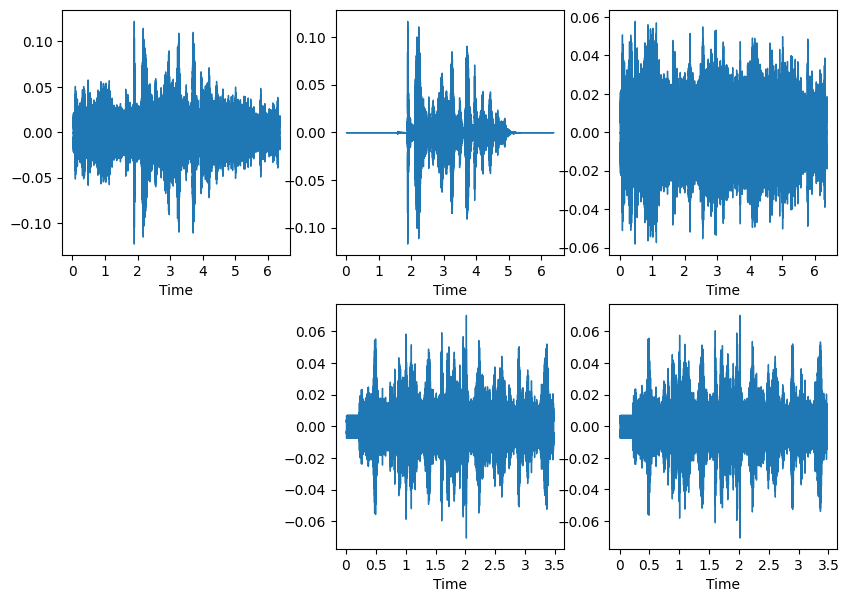

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa.display

fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)

librosa.display.waveshow(mixed[1], sr=44100)

fig.add_subplot(rows, columns, 2)

librosa.display.waveshow(target[1], sr=44100)

fig.add_subplot(rows, columns, 3)

librosa.display.waveshow(noise[1], sr=44100)

fig.add_subplot(rows, columns, 5)

librosa.display.waveshow(s_pred_voice_wav, sr=44100)

fig.add_subplot(rows, columns, 6)

librosa.display.waveshow(s_pred_noise_wav, sr=44100)

plt.show()


In [28]:
from scipy.io import wavfile
wavfile.write(
            "enhanced.wav", 44100, s_pred_voice_wav
        )
